# LSTM Classification of 6 Most Common Plastics from Fourier Transform Infrared Spectroscopy (FTIR): Exploratory Data Analysis

## Introduction

Fourier Transform Infrared Spectroscopy is a fast and inexpensive analytical tool that sees widespread use for quality assurance and environmental monitoring, as well as in many domains of research. However standardization across use cases is minimal and most comprehensive resources for learning to fully interpret spectra are still only in textbooks. Deep learning interpretation in FTIR is currently an under-explored domain, especially given the sheer density of information that an FTIR spectra can capture, and in such a machine-accessible record! 

Researchers from University of Mexico have published 6000 FTIR spectra, 1000 each of 6 of the most common plastics used in consumer goods: High-Density Polyethylene (HDPE), Low-Density Polyethylene (LDPE), Polyethylene Terephthalate (PET), Polypropylene (PP), Polystyrene (PS), and Polyvinyl Chloride (PVC). For this project we will be using this data to build an LSTM to process the FTIR signal and classify it correctly. 

Dataset provided on Zenodo:  
[![DOI](https://zenodo.org/badge/DOI/10.52821/zenodo.10736650.svg)](https://doi.org/10.52821/zenodo.10736650)

*Instructions:* To use this notebook, you must download the above dataset, unzip it to the folder "*this-repo*/data/", unzip both resultant folders in-place (FTIR-PLASTIC-c4 and FTIR-PLASTIC-c8) and then unzip the six folders inside each of those folders in-place (HDPE, LDPE, PET, PP, PS, and PVC). The unzipped data occupies about 196MB. 


In [1]:
# Utility and preprocessing imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# Set up some environment variables

# Our random state for splitting
rseed=1812


# These are the plastics we'll be labeling
polymers = ['HDPE','LDPE','PET','PP','PS','PVC']

In [ ]:
# Grab two same-material spectra, one from each set - ignore metadata, first column is wavenumber, second column is transmittance
sample_c8 = np.array(pd.read_csv(f"data/FTIR-PLASTIC-c8/HDPE_c8/HDPE54.csv", skiprows=range(0,14)))
sample_c4 = pd.read_csv(f"data/FTIR-PLASTIC-c4/HDPE_c4/HDPE54.csv", skiprows=range(0,14)))
sample_c8

array([[ 399.1927,  105.355 ],
       [ 401.1211,  104.055 ],
       [ 403.0496,  102.816 ],
       ...,
       [3997.7119,  102.301 ],
       [3999.6404,  102.306 ],
       [4001.5688,  102.29  ]])

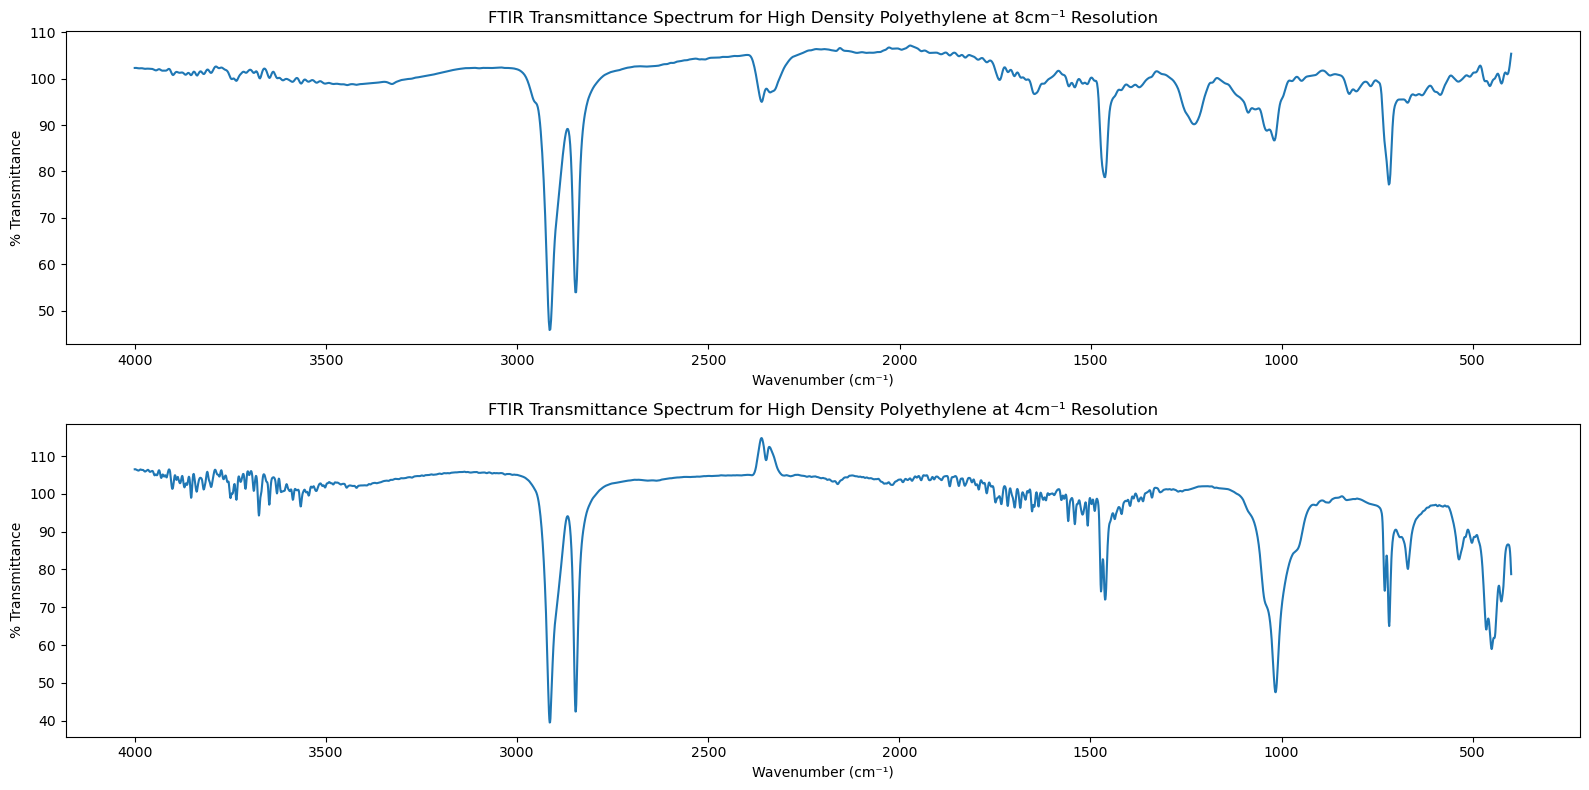

In [4]:
#vizualize our sample spectra
fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(16,8))
sns.lineplot(x=sample_c8[:,0], y=sample_c8[:,1],ax=ax1)
ax1.set_xlabel("Wavenumber (cm⁻¹)")
ax1.set_ylabel("% Transmittance")
ax1.set_title("FTIR Transmittance Spectrum for High Density Polyethylene at 8cm⁻¹ Resolution")
ax1.invert_xaxis() 
sns.lineplot(x=sample_c4[:,0], y=sample_c4[:,1],ax=ax2)
ax2.set_xlabel("Wavenumber (cm⁻¹)")
ax2.set_ylabel("% Transmittance")
ax2.set_title("FTIR Transmittance Spectrum for High Density Polyethylene at 4cm⁻¹ Resolution")
ax2.invert_xaxis() 
plt.tight_layout()

So, this is NOT the cleanest FTIR data - and that's ok! Transmissions obviously shouldn't go over 100%, so there are some calibration issues, but we care a lot more about the signal shape than the actual values, especially for just classifying to the general material. This is still human-readable for this task, the signal structure is consistent, and most importantly it's a very large set for this kind of data. In this particular spectrum we do see the polyethylene split peak at around 2900, so that's encouraging, but the "fingerprint" region at lower wavenumbers tends to be very noisy, although you can see some similarities, it's clear that these HDPE plastics are not identical. 

In [5]:
# Let's double-check the assumption that taking every other point in c4 spectrum gets the same wavenumbers as c8 minus the last datapoint.

assert np.equal(sample_c4[::2,0],sample_c8[:-1,0]).all()

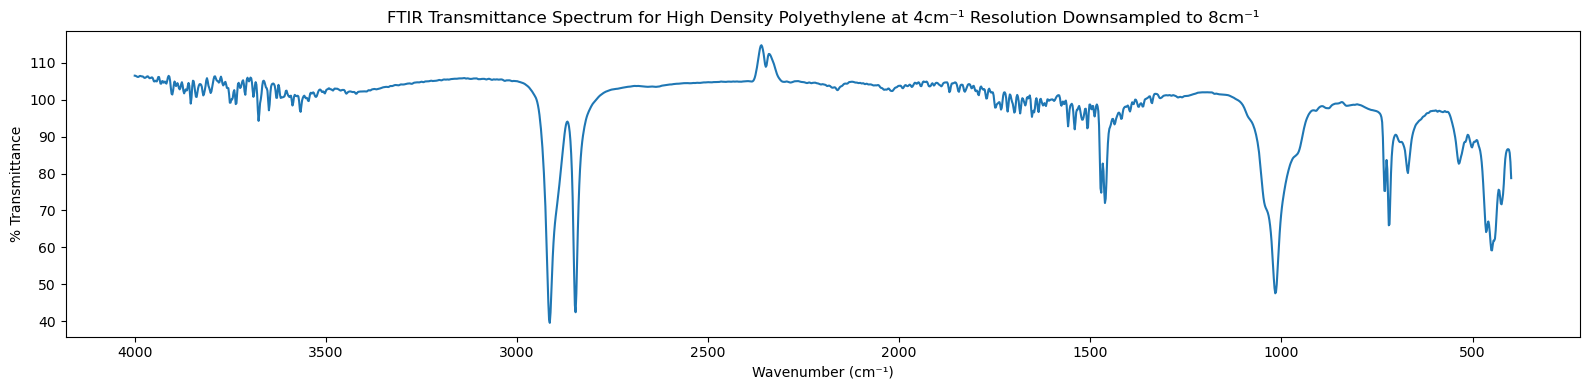

In [6]:
# Now we down-convert 4cm⁻¹ spectra and visualize to inspect. 

fig,ax = plt.subplots(figsize=(16,4))
sns.lineplot(x=sample_c4[::2,0],y=sample_c4[::2,1])
ax.set_xlabel("Wavenumber (cm⁻¹)")
ax.set_ylabel("% Transmittance")
ax.set_title("FTIR Transmittance Spectrum for High Density Polyethylene at 4cm⁻¹ Resolution Downsampled to 8cm⁻¹")
ax.invert_xaxis() 
plt.tight_layout()

So now we have confirmed that our c8 spectra can be easily merged with our c4 spectra, granting us a true bounty of data to work with. 

In [ ]:
# Time to get our full dataset loaded or built. 
if os.path.exists('data/data_train.csv'):
    data_train = pd.read_csv('data/data_train.csv', index_col=False)
    data_test = pd.read_csv('data/data_test.csv', index_col=False)

else:
    # Now that we know how to do direct conversion, we can import everything 
    data = np.hstack((sample_c8[:-1,0]))
    labels = ['label']


    for pm in polymers:

        for n in range(1,501): # samples are labeled 1 to 500 for each material in both c4 and c8 sets.
            data = np.vstack([
                                data,
                                np.array(pd.read_csv(f"data/FTIR-PLASTIC-c4/{pm}_c4/{pm}{n}.csv",skiprows=range(0,14)))[::2,1],
                                np.array(pd.read_csv(f"data/FTIR-PLASTIC-c8/{pm}_c8/{pm}{n}.csv",skiprows=range(0,14)))[:-1,1]
                                ])
            labels=np.vstack([labels,[pm],[pm]])
    

    # Need to divide signals by 100 to bring percentages to (mostly) between 0 and 1. 
    # I think relative signal intensities might be important between HDPE and LDPE 
    # so I'm opting not to further normalize signals for now

    data[1:,:] = data[1:,:]/100

    # And here's the whole thing!    
    data_df = pd.DataFrame(data[1:,:], columns=data[0,:])
    data_df['label'] = labels[1:]

    # Now let's split off a holdout set and then save both sets to avoid having to preprocess again.
    data_test, data_train = train_test_split(data_df, train_size=0.15, random_state=rseed)

    # Lets save that back out so we can load it up in just a second next time.
    data_train.to_csv('data/data_train.csv', index=False)
    data_test.to_csv('data/data_test.csv', index=False)



In [8]:
data_train.head(15)

,399.1927,401.1211,403.0496,404.9781,406.9065,408.835,410.7635,412.6919,414.6204,416.5489,...,3984.2126,3986.1411,3988.0696,3989.998,3991.9265,3993.855,3995.7834,3997.7119,3999.6404,label
0,0.945961,0.964486,0.980928,0.993397,1.001330,1.002310,0.998090,0.994694,0.991937,0.983539,...,1.008670,1.008870,1.008150,1.007300,1.007060,1.007330,1.007930,1.008570,1.008690,PS
1,0.809655,0.805031,0.795515,0.791262,0.792448,0.795575,0.798560,0.797837,0.793198,0.792618,...,1.035150,1.035170,1.035240,1.035310,1.035360,1.035380,1.035310,1.035200,1.035180,PVC
2,0.796955,0.835657,0.855075,0.861155,0.860699,0.857605,0.851536,0.840940,0.824175,0.797778,...,1.032410,1.032730,1.031760,1.030640,1.030520,1.031130,1.032070,1.032990,1.033250,HDPE
3,0.990981,0.992019,0.993716,0.995531,0.997020,0.997845,0.997776,0.996734,0.994874,0.992641,...,0.971808,0.971791,0.971734,0.971666,0.971612,0.971590,0.971600,0.971625,0.971646,PP
4,0.994545,1.003460,1.008030,1.010370,1.012290,1.014970,1.017900,1.018600,1.014630,1.006780,...,1.013790,1.014000,1.013300,1.012560,1.012600,1.013040,1.013510,1.014010,1.014240,LDPE
5,0.979895,0.994678,1.004160,1.014110,1.022350,1.025330,1.027570,1.029430,1.021800,1.003980,...,1.069150,1.069530,1.068540,1.067410,1.067380,1.068030,1.068870,1.069730,1.070070,LDPE
6,0.936071,0.940017,0.944230,0.947624,0.949744,0.950618,0.950498,0.949708,0.948599,0.947565,...,1.053300,1.053300,1.053220,1.053120,1.053040,1.053040,1.053120,1.053240,1.053360,PET
7,0.916840,0.941423,0.960024,0.970743,0.975566,0.975559,0.974027,0.973916,0.970049,0.957469,...,1.028090,1.028370,1.027690,1.026690,1.026250,1.026550,1.027400,1.028220,1.028420,PS
8,1.024240,1.023930,1.025530,1.027900,1.030100,1.031380,1.031140,1.028990,1.025030,1.020000,...,1.089420,1.089340,1.089150,1.088970,1.088890,1.088990,1.089230,1.089530,1.089760,LDPE
9,0.845134,0.844998,0.839748,0.837216,0.841705,0.846720,0.844996,0.839737,0.836067,0.832928,...,0.983769,0.983774,0.983637,0.983493,0.983486,0.983588,0.983762,0.983962,0.984075,PET


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Columns: 1869 entries, 399.1927 to label
dtypes: float64(1868), object(1)
memory usage: 72.7+ MB


In [10]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 1869 entries, 399.1927 to label
dtypes: float64(1868), object(1)
memory usage: 12.8+ MB


In [11]:
data_train.isna().sum().value_counts(), data_train.isna().sum().value_counts() # no nulls

(0    1869
 Name: count, dtype: int64,
 0    1869
 Name: count, dtype: int64)

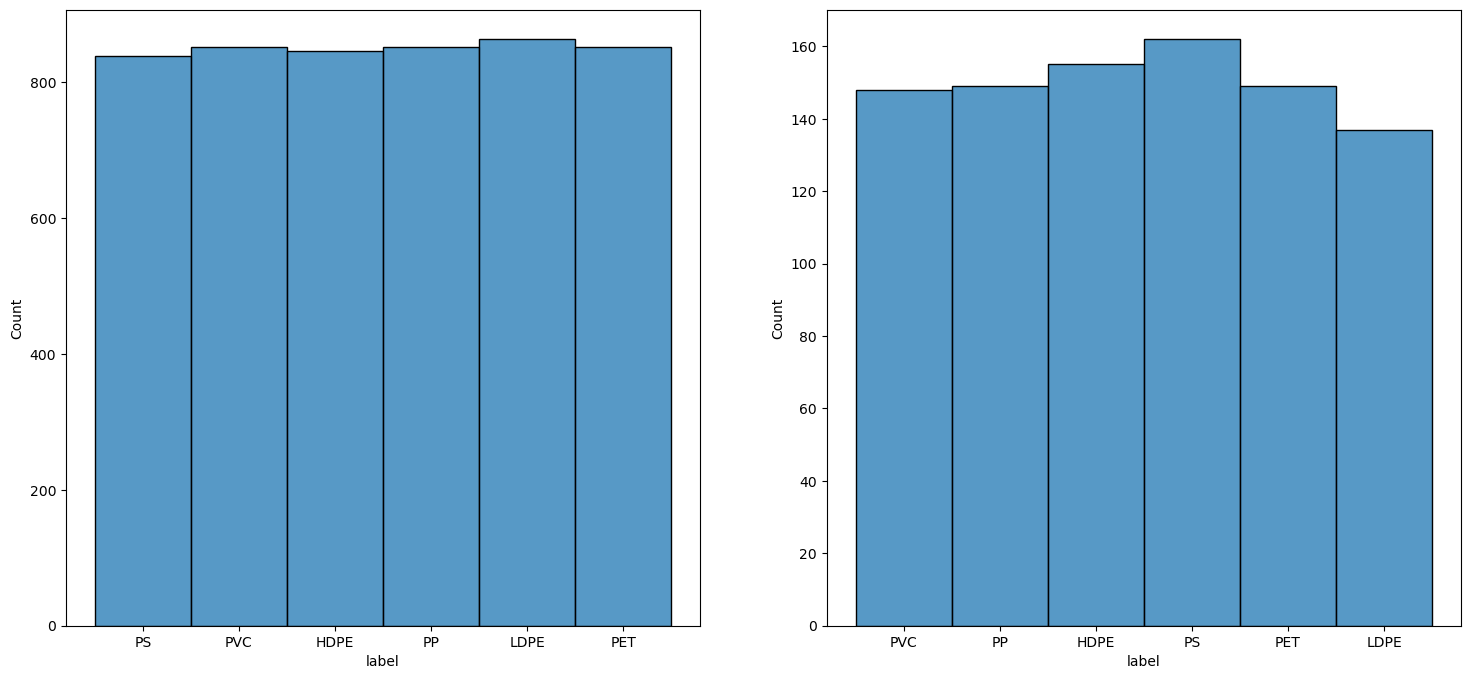

In [14]:
# Quick histograms to make sure target distributions are still balanced enough
fig,[ax1,ax2] =plt.subplots(ncols=2,figsize=(18,8))
sns.histplot(data=data_train['label'],ax=ax1)
sns.histplot(data=data_test['label'],ax=ax2);

Our test is a little lumpy, but seems like it should be ok. 

Next, let's visualize our other 5 materials!

In [31]:
# First we need to load them in

HDPE_c8 =  pd.read_csv(f"data/FTIR-PLASTIC-c8/HDPE_c8/HDPE324.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','1884':'Transmittance'})
HDPE_c4 =  pd.read_csv(f"data/FTIR-PLASTIC-c4/HDPE_c4/HDPE324.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','3751':'Transmittance'})
LDPE_c8 =  pd.read_csv(f"data/FTIR-PLASTIC-c8/LDPE_c8/LDPE54.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','1884':'Transmittance'})
LDPE_c4 =  pd.read_csv(f"data/FTIR-PLASTIC-c4/LDPE_c4/LDPE54.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','3751':'Transmittance'})
PET_c8 =  pd.read_csv(f"data/FTIR-PLASTIC-c8/PET_c8/PET54.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','1884':'Transmittance'})
PET_c4 =  pd.read_csv(f"data/FTIR-PLASTIC-c4/PET_c4/PET54.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','3751':'Transmittance'})
PP_c8 =  pd.read_csv(f"data/FTIR-PLASTIC-c8/PP_c8/PP54.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','1884':'Transmittance'})
PP_c4 =  pd.read_csv(f"data/FTIR-PLASTIC-c4/PP_c4/PP54.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','3751':'Transmittance'})
PS_c8 =  pd.read_csv(f"data/FTIR-PLASTIC-c8/PS_c8/PS54.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','1884':'Transmittance'})
PS_c4 =  pd.read_csv(f"data/FTIR-PLASTIC-c4/PS_c4/PS54.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','3751':'Transmittance'})
PVC_c8 =  pd.read_csv(f"data/FTIR-PLASTIC-c8/PVC_c8/PVC54.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','1884':'Transmittance'})
PVC_c4 =  pd.read_csv(f"data/FTIR-PLASTIC-c4/PVC_c4/PVC54.csv", skiprows=range(0,14)).rename(columns={'NPOINTS:':'Wavenumber','3751':'Transmittance'})

# Collect them all
sample_list = [HDPE_c4,HDPE_c8,LDPE_c8,LDPE_c4,PET_c4,PET_c8,PP_c4,PP_c8,PS_c4,PS_c8,PVC_c4,PVC_c8]
title_list = ['HDPE_c4','HDPE_c8','LDPE_c8','LDPE_c4','PET_c4','PET_c8','PP_c4','PP_c8','PS_c4','PS_c8','PVC_c4','PVC_c8']

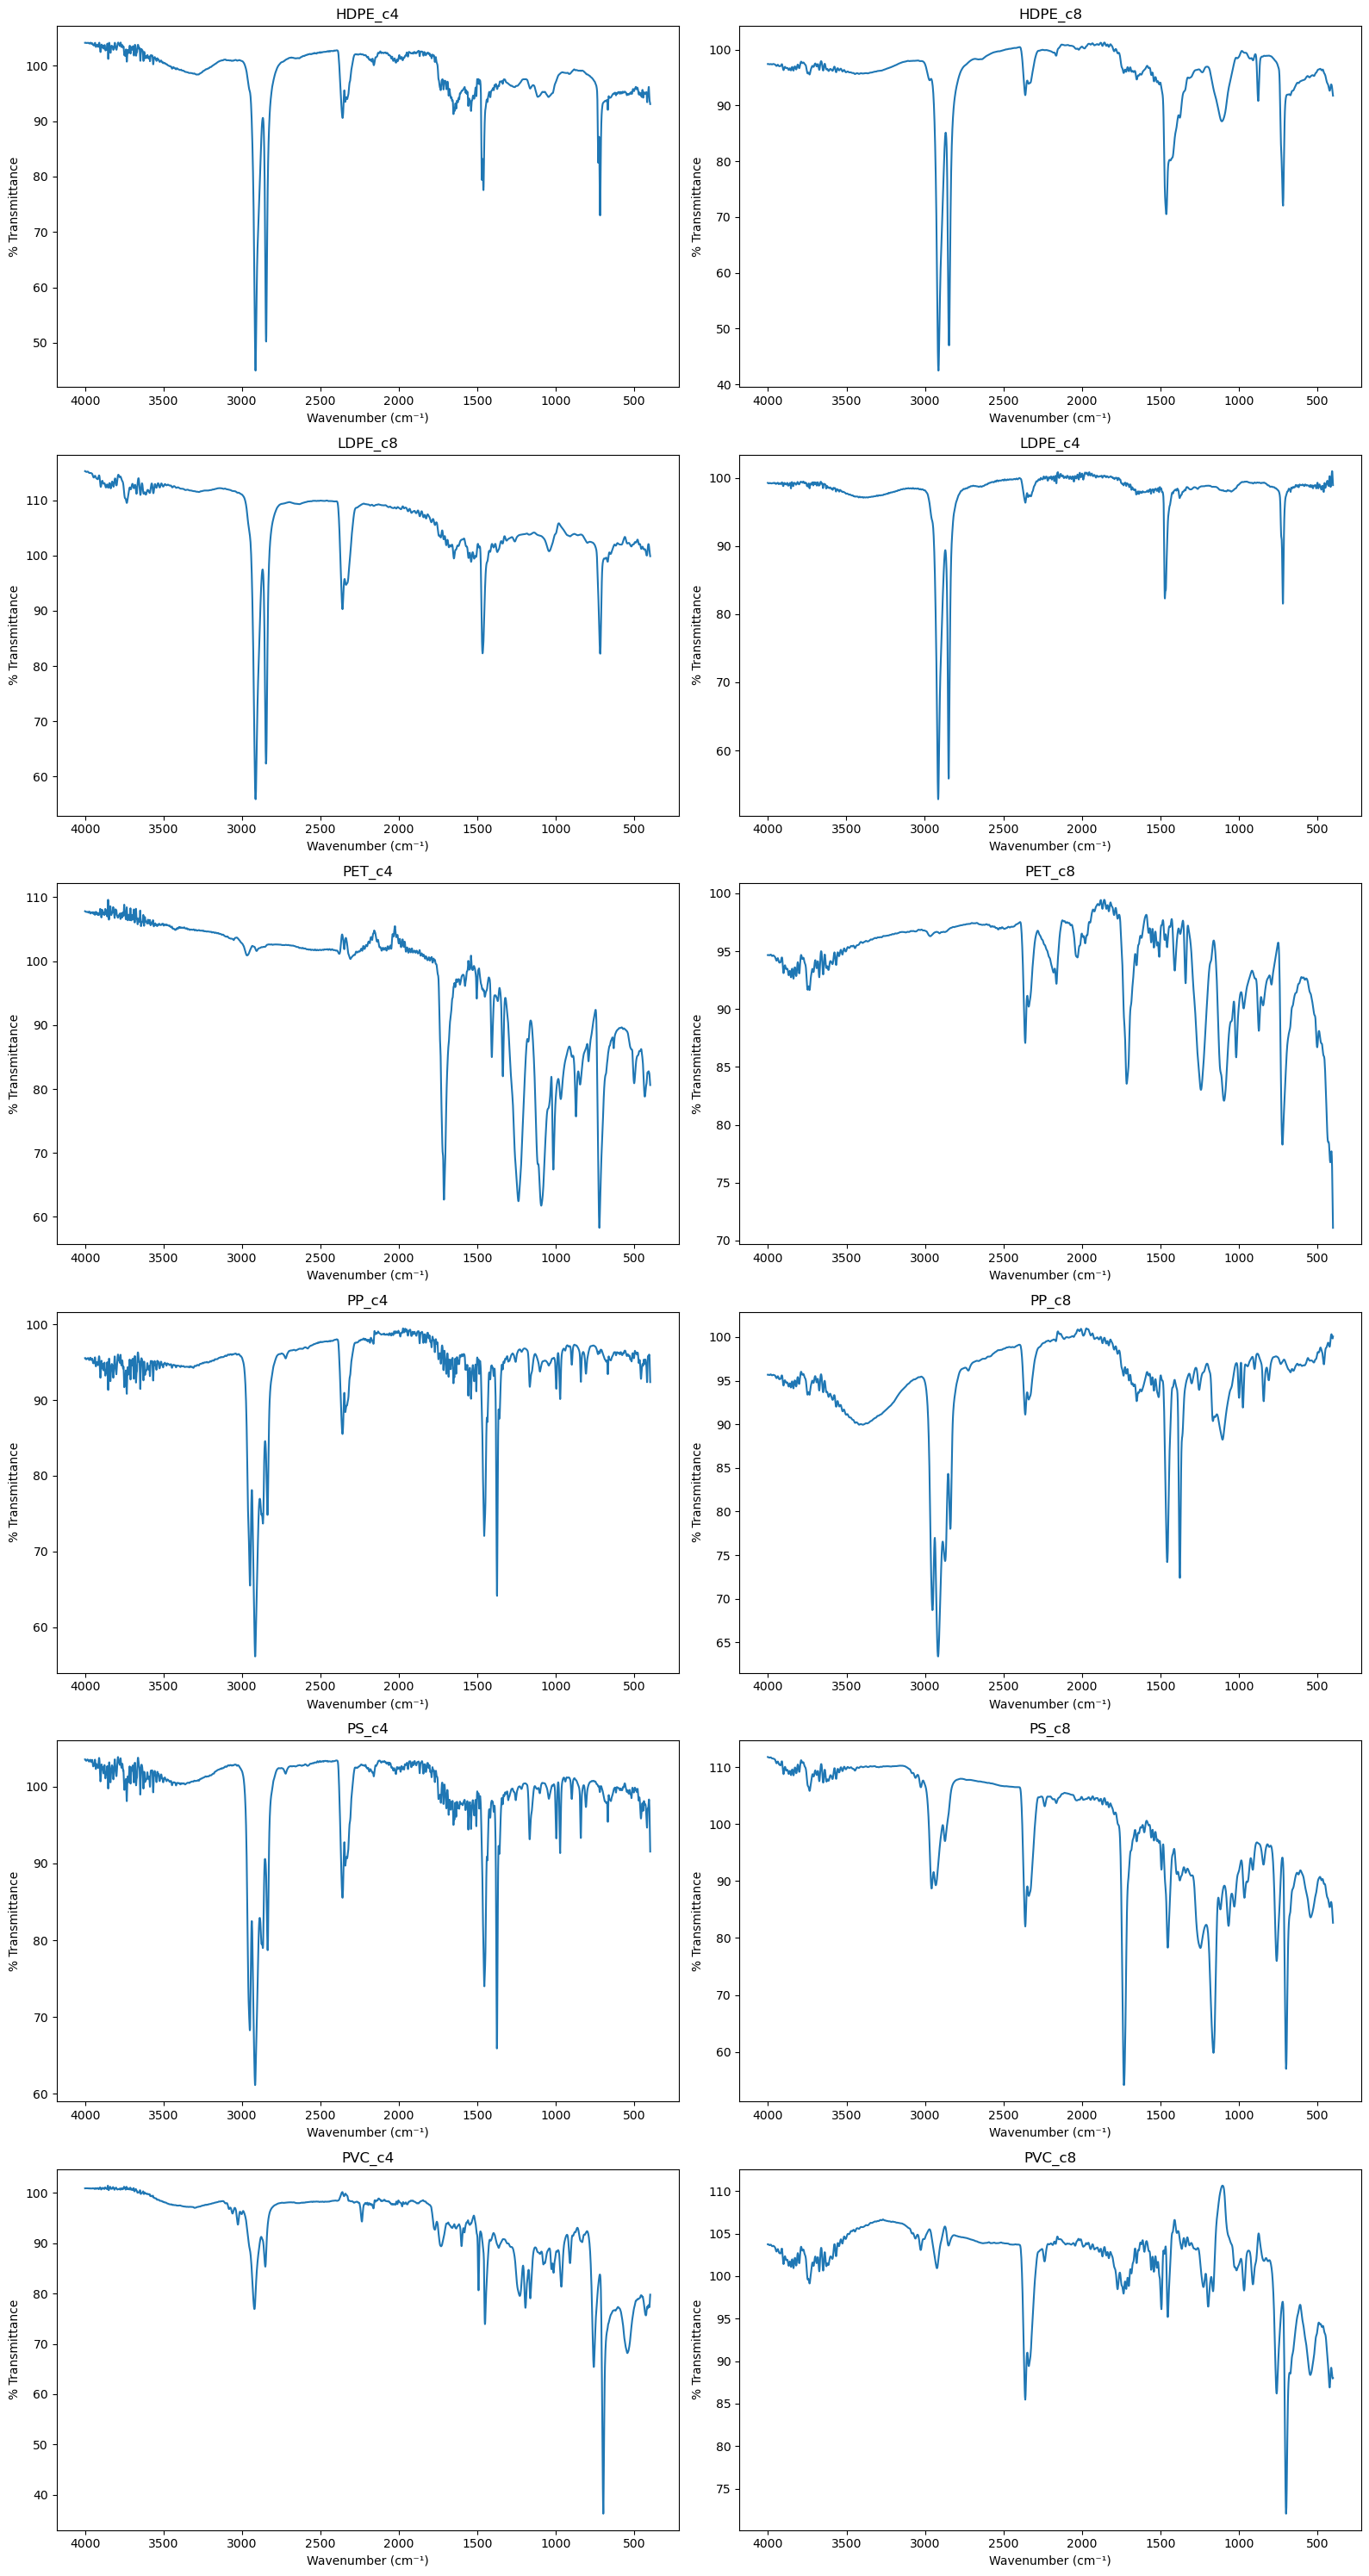

In [33]:
# Iterate and visualize
fig, axes = plt.subplots(ncols=2,nrows=6,figsize=(16,30))
for i,elem in enumerate(sample_list):
    ax=axes[i//2,i%2]
    sns.lineplot(data=elem, x='Wavenumber',y='Transmittance', ax=ax)
    ax.set_xlabel("Wavenumber (cm⁻¹)")
    ax.set_ylabel("% Transmittance")
    ax.set_title(f"{title_list[i]}")
    ax.invert_xaxis() 
plt.tight_layout()

## Analysis

HDPE and LDPE are the hardest to tell apart because they are the same polymer with different levels of crystallinity. Everything else is 